# SynthAX Walk-through

We walk through basic functionality of `synthax` in this Jupyter notebook.

Just note that all ipd.Audio play widgets normalize the audio.

If you're in Colab, remember to set the runtime to GPU and get the latest SynthAX:

```
!pip install git+https://github.com/PapayaResearch/synthax.git
```

If you're running on a GPU outside of Google Colab, in order to leverage the JAX acceleration you have to install the package following these [instructions](https://github.com/google/jax#installation).

In [ ]:
!pip install matplotlib librosa

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
    
import jax
import jax.numpy as jnp
import numpy as np
from synthax.config import SynthConfig
from synthax.parameter import ModuleParameterRange, ModuleParameterSpec
from synthax.synth import Voice, ParametricSynth
from synthax.modules.oscillators import SineVCO, FmVCO, SquareSawVCO, Noise
from synthax.modules.envelopes import ADSR
from synthax.modules.lfos import LFO
from synthax.modules.amplifiers import VCA, ControlRateVCA
from synthax.modules.mixers import AudioMixer, ModulationMixer
from synthax.modules.control import ControlRateUpsample
from synthax.modules.keyboard import MonophonicKeyboard

Define two useful functions to plot the amplitude over time and the short-time Fourier Transform (STFT)

In [3]:
def time_plot(signal, sample_rate=44100):
    t = jnp.linspace(0, len(signal) / sample_rate, len(signal), endpoint=False)
    plt.plot(t, signal)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [4]:
def stft_plot(signal, sample_rate=44100):
    X = librosa.stft(np.asarray(signal))
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis="time", y_axis="log")
    plt.show()

## Random Key

JAX uses pseudo-random number generation (PRNG) keys to approximate the properties of sequences of random numbers. These generators receive a seed to be deterministic and can be split to ensure different values while remaining deterministic.

In [5]:
class PRNGKey():
    def __init__(self):
        self.PRNG_key = jax.random.PRNGKey(42)
    def split(self):
        self.PRNG_key, subkey = jax.random.split(self.PRNG_key)
        return subkey
        
PRNG_key = PRNGKey()

## Configs

We're going to define multiple configurations (see `synthax.config`) to showcase the possibilities.

- config1: Generates two sounds of 4 seconds each at once with a sampling rate of 44,100Hz
- config2: Generates one sound of 4 seconds each at once with a sampling rate of 44,100Hz

In [6]:
config1 = SynthConfig(
    batch_size=2,
    sample_rate=44100,
    buffer_size_seconds=4.0
)

In [7]:
config2 = SynthConfig(
    batch_size=1,
    sample_rate=44100,
    buffer_size_seconds=4.0
)

## Envelopes
The `ADSR` envelope stands for Attack Decay Sustain Release, which is specified by four values:

- attack: the attack time in seconds; the time it takes for the signal to ramp from 0 to 1.
- decay: the decay time in seconds; the time to 'decay' from a peak of 1 to a sustain level.
- sustain: the sustain level; a value between 0 and 1 that the envelope holds during a sustained note.
- release: the release time in seconds; the time it takes the signal to decay from the sustain value to 0.

Envelopes (see `synthax.modules.envelopes`) are used to modulate a variety of signals; usually one of pitch, amplitude, or filter cutoff frequency. In this notebook we will use the same envelope to modulate several different audio parameters.

### A note about note-on, note-off behaviour

By default, this envelope reacts as if it was triggered with midi, for example
playing a keyboard. Each midi event has a beginning and end: note-on, when you
press the key down; and note-off, when you release the key. `note_on_duration`
is the amount of time that the key is depressed. During the note-on, the
envelope moves through the attack and decay sections of the envelope. This
leads to musically-intuitive, but programatically-counterintuitive behaviour.

Assume attack is 0.5 seconds, and decay is 0.5 seconds. If a note is held for
0.75 seconds, the envelope won't traverse through the entire attack-and-decay
phase (specifically, it will execute the entire attack, and 0.25 seconds of
the decay).

### Setting the initial values

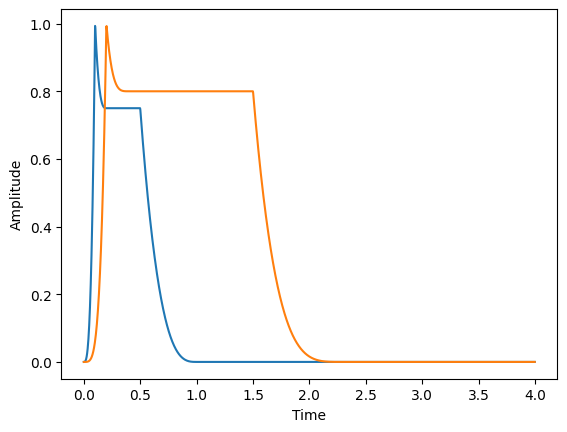

ADSR(
    # attributes
    config = SynthConfig({'batch_size': 2, 'sample_rate': 44100, 'buffer_size_seconds': 4.0, 'buffer_size': 176400, 'control_rate': 441, 'control_buffer_size': 1764, 'eps': 1e-06})
    PRNG_key = Array([255383827, 267815257], dtype=uint32)
    attack = Array([0.1, 0.2], dtype=float32)
    decay = Array([0.1, 0.2], dtype=float32)
    sustain = Array([0.75, 0.8 ], dtype=float32)
    release = Array([0.5, 0.8], dtype=float32)
    alpha = Array([3., 4.], dtype=float32)
)


In [8]:
# Synthesis parameters.
attack = jnp.array([0.1, 0.2])
decay = jnp.array([0.1, 0.2])
sustain = jnp.array([0.75, 0.8])
release = jnp.array([0.5, 0.8])
alpha = jnp.array([3.0, 4.0])

# Envelope test
adsr = ADSR(
    config=config1,
    PRNG_key=PRNG_key.split(),
    attack=attack,
    decay=decay,
    sustain=sustain,
    release=release,
    alpha=alpha,
)

note_on_duration = jnp.array([0.5, 1.5])
params = adsr.init(PRNG_key.split(), note_on_duration)
apply = jax.jit(adsr.apply)
envelope = apply(params, note_on_duration)

# Plot
time_plot(envelope.T, adsr.control_rate)
print(adsr)

We can calculate the L1 error between the two envelopes

Error = 0.23170947


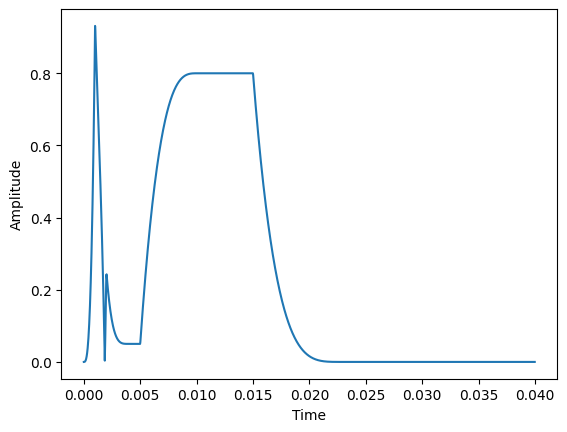

In [9]:
diff = jnp.abs(envelope[0, :] - envelope[1, :])
err = jnp.mean(diff)
print("Error =", err)
time_plot(diff.T)

### Gradients
**TODO**

### Random initial values

The parameters are intitialized randomly by default.

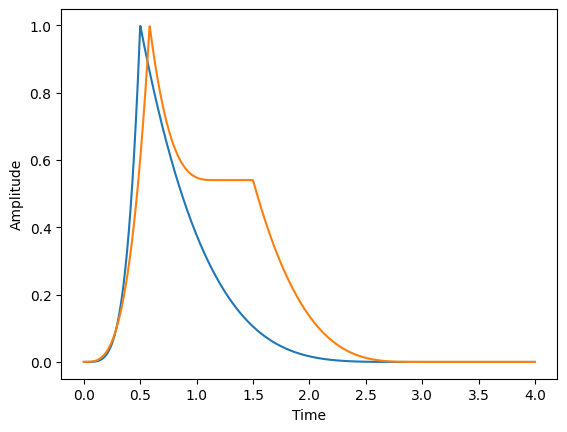

ADSR(
    # attributes
    config = SynthConfig({'batch_size': 2, 'sample_rate': 44100, 'buffer_size_seconds': 4.0, 'buffer_size': 176400, 'control_rate': 441, 'control_buffer_size': 1764, 'eps': 1e-06})
    PRNG_key = Array([1371681402, 3011037117], dtype=uint32)
    attack = ModuleParameterRange(minimum=0.0, maximum=2.0, curve=0.5, symmetric=False)
    decay = ModuleParameterRange(minimum=0.0, maximum=2.0, curve=0.5, symmetric=False)
    sustain = ModuleParameterRange(minimum=0.0, maximum=1.0, curve=1.0, symmetric=False)
    release = ModuleParameterRange(minimum=0.0, maximum=5.0, curve=0.5, symmetric=False)
    alpha = ModuleParameterRange(minimum=0.1, maximum=6.0, curve=1.0, symmetric=False)
)


In [11]:
# Envelope test
adsr = ADSR(
    config=config1,
    PRNG_key=PRNG_key.split(),
)

note_on_duration = jnp.array([0.5, 1.5])
params = adsr.init(PRNG_key.split(), note_on_duration)
apply = jax.jit(adsr.apply)
envelope = apply(params, note_on_duration)

# Plot
time_plot(envelope.T, adsr.control_rate)
print(adsr)

## Oscillators

There are several types of oscillators (see `synthax.modules.oscillators`) and sound generators available. Oscillators that can be controlled by an external signal are called voltage-coltrolled oscillators (VCOs) in the analog world and we adpot a similar approach here. Oscillators accept an input control signal and produce audio output. We have a simple sine oscilator (`SineVCO`), a square/saw oscillator (`SquareSawVCO`), and an FM oscillator (`FmVCO`). There is also a white noise generator (`Noise`).

### SineVCO

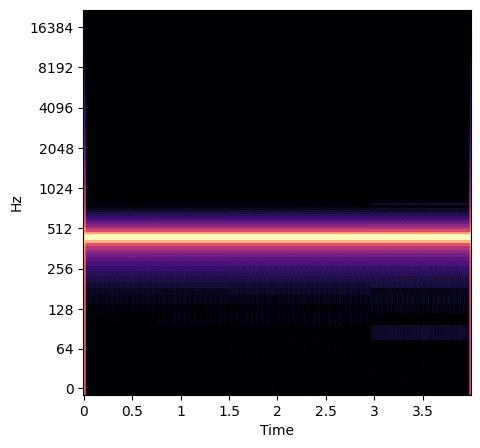

In [12]:
# Set up a Keyboard module
keyboard = MonophonicKeyboard(
    config=config1,
    PRNG_key=PRNG_key.split(),
    midi_f0=jnp.array([69.0, 50.0]),
    duration=jnp.array([0.5, 1.5])
)

# Trigger the keyboard, which returns a midi_f0 and note duration
params = keyboard.init(PRNG_key.split())
apply = jax.jit(keyboard.apply)
midi_f0, duration = apply(params)

# Instantiate the sine wave VCO with tuning set to zero
sine_vco = SineVCO(
    config=config1,
    PRNG_key=PRNG_key.split(),
    tuning=jnp.array([0.0, 0.0]),
)

# Call the sine_vco with the midi_f0
params = sine_vco.init(PRNG_key.split(), midi_f0)
apply = jax.jit(sine_vco.apply)
out = apply(params, midi_f0)

stft_plot(out[0])
ipd.display(ipd.Audio(out[0], rate=sine_vco.sample_rate))

VCOs have an optional pitch modulation argument that can be passed in during generation. Let's create a `SineVCO` modulated with an envelope.

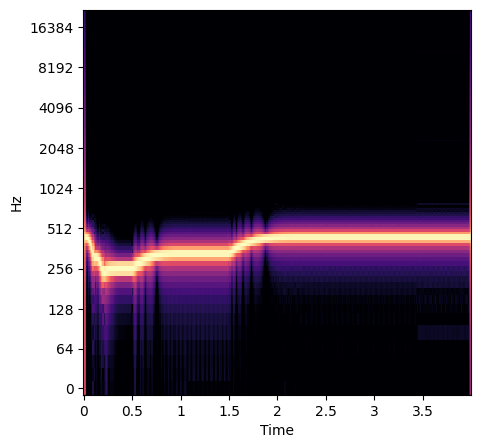

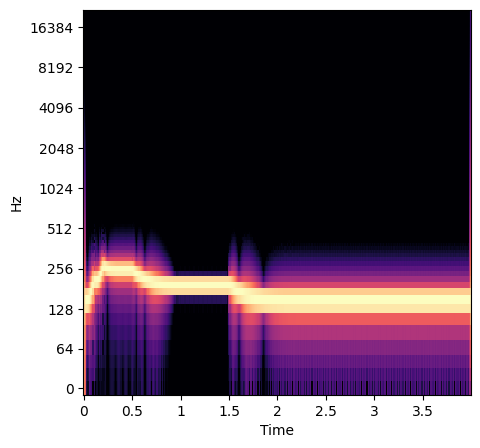

Error = 0.8061071


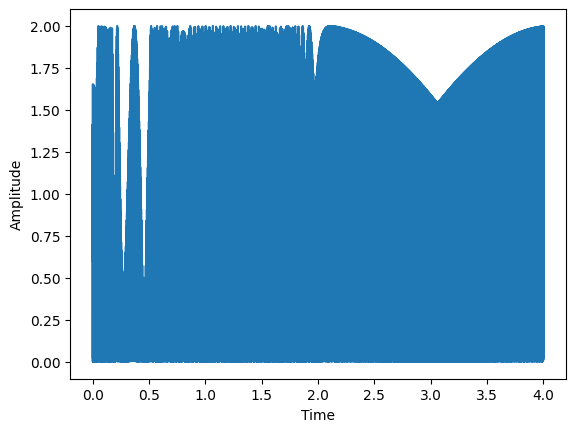

In [13]:
# Synthesis parameters.
attack = jnp.array([0.1, 0.2])
decay = jnp.array([0.1, 0.2])
sustain = jnp.array([0.75, 0.8])
release = jnp.array([0.5, 0.8])
alpha = jnp.array([3.0, 4.0])
note_on_duration = jnp.array([0.5, 1.5])

### Modules
# Set up a Keyboard module
keyboard = MonophonicKeyboard(
    config=config1,
    PRNG_key=PRNG_key.split(),
    midi_f0=jnp.array([69.0, 50.0]),
    duration=note_on_duration
)

# Envelope test
adsr = ADSR(
    config=config1,
    PRNG_key=PRNG_key.split(),
    attack=attack,
    decay=decay,
    sustain=sustain,
    release=release,
    alpha=alpha,
)

# Upsample
upsample = ControlRateUpsample(
    config=config1,
    PRNG_key=PRNG_key.split(),
)

### Calls
# Trigger the keyboard, which returns a midi_f0 and note duration
params = keyboard.init(PRNG_key.split())
apply = jax.jit(keyboard.apply)
midi_f0, duration = apply(params)

# Create an envelope -- modulation signals are computed at a lower
# sampling rate and must be upsampled prior to feeding into audio
# rate modules
params = adsr.init(PRNG_key.split(), note_on_duration)
apply = jax.jit(adsr.apply)
envelope = apply(params, note_on_duration)

params = upsample.init(PRNG_key.split(), envelope)
apply = jax.jit(upsample.apply)
envelope = apply(params, envelope)
envelope = upsample(envelope)

# Instantiate the sine wave VCO
sine_vco = SineVCO(
    config=config1,
    PRNG_key=PRNG_key.split(),
    tuning=jnp.array([0.0, 0.0]),
    mod_depth=jnp.array([-12.0, 12.0]),
)

# Call the sine_vco with the midi_f0
params = sine_vco.init(PRNG_key.split(), midi_f0, envelope)
apply = jax.jit(sine_vco.apply)
sine_out = apply(params, midi_f0, envelope)

stft_plot(sine_out[0])
ipd.display(ipd.Audio(sine_out[0], rate=sine_vco.sample_rate))
stft_plot(sine_out[1])
ipd.display(ipd.Audio(sine_out[1], rate=sine_vco.sample_rate))

# We can use auraloss instead of raw waveform loss. This is just
# to show that gradient computations occur
diff = jnp.abs(sine_out[0] - sine_out[1])
err = jnp.mean(diff)
print("Error =", err)
time_plot(diff)

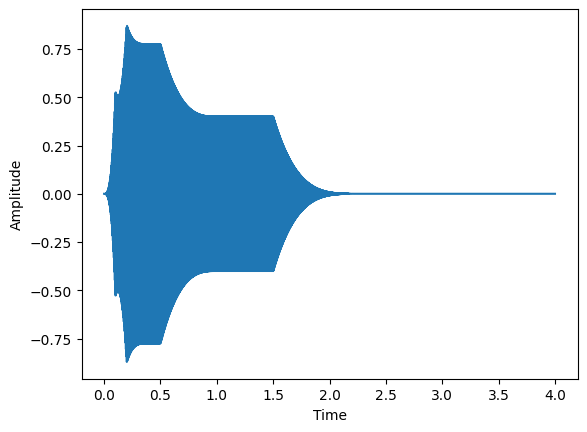

In [14]:
vca = VCA(config=config1, PRNG_key=PRNG_key.split())
params = vca.init(PRNG_key.split(), envelope, sine_out)
apply = jax.jit(vca.apply)
test_out = apply(params, envelope, sine_out)

time_plot(test_out[0])

### SquareSaw Oscillator

Now, let's use a `SquareSawVCO` oscillator. Use the shape parameter to
interpolate between a square wave (shape = 0) and a sawtooth wave (shape = 1).

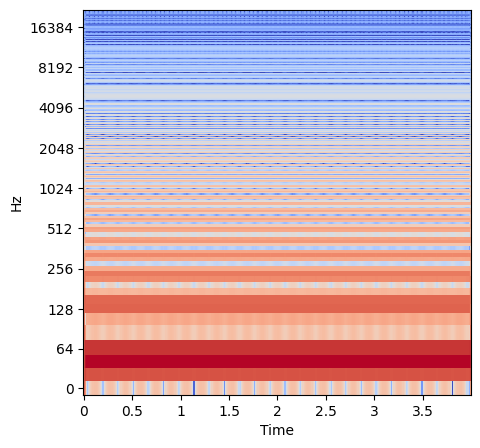

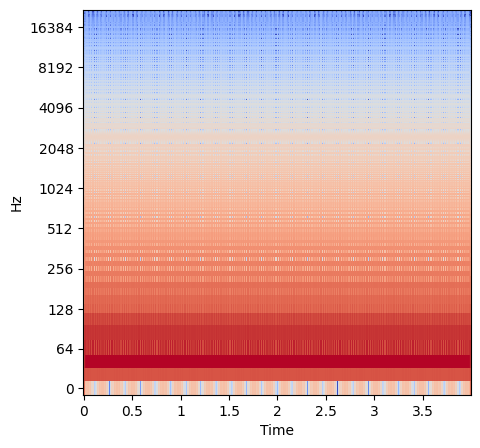

Error:  1.0377445


In [15]:
# Set up a Keyboard module
keyboard = MonophonicKeyboard(
    config=config1,
    PRNG_key=PRNG_key.split(),
    midi_f0=jnp.array([30.0, 30.0]),
    duration=jnp.array([0.5, 1.5])
)

# Trigger the keyboard, which returns a midi_f0 and note duration
params = keyboard.init(PRNG_key.split())
apply = jax.jit(keyboard.apply)
midi_f0, duration = apply(params)

# Instantiate the sine wave VCO with tuning set to zero
square_saw = SquareSawVCO(
    config=config1,
    PRNG_key=PRNG_key.split(),
    tuning=jnp.array([0.0, 0.0]),
    mod_depth=jnp.array([0.0, 0.0]),
    shape=jnp.array([0.0, 1.0]),
)

# Envelope
env = jnp.zeros([2, square_saw.buffer_size])

# Call the sine_vco with the midi_f0
params = square_saw.init(PRNG_key.split(), midi_f0, env)
apply = jax.jit(square_saw.apply)
square_saw_out = apply(params, midi_f0, env)

stft_plot(square_saw_out[0])
ipd.display(ipd.Audio(square_saw_out[0], rate=square_saw.sample_rate))
stft_plot(square_saw_out[1])
ipd.display(ipd.Audio(square_saw_out[1], rate=square_saw.sample_rate))

err = jnp.mean(jnp.abs(square_saw_out[0] - square_saw_out[1]))
print("Error: ", err)

### FM Synthesis

The `FmVCO` class accepts any audio input.

Just a note that, as in classic FM synthesis, you're dealing with a complex
architecture of modulators. Each 'operator ' has its own pitch envelope, and
amplitude envelope. The 'amplitude' envelope of an operator is really the
*modulation depth* of the oscillator it operates on. So in the example below,
we're using an ADSR to shape the depth of the *operator*, and this affects
the modulation depth of the resultant signal.

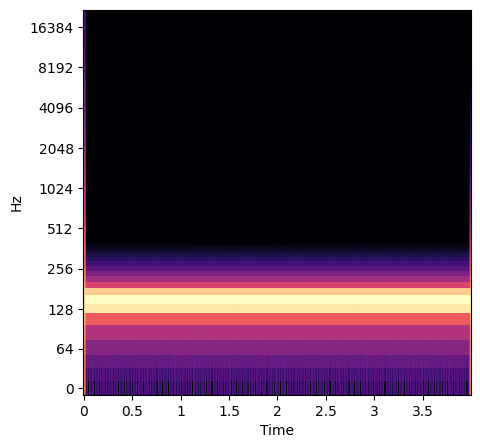

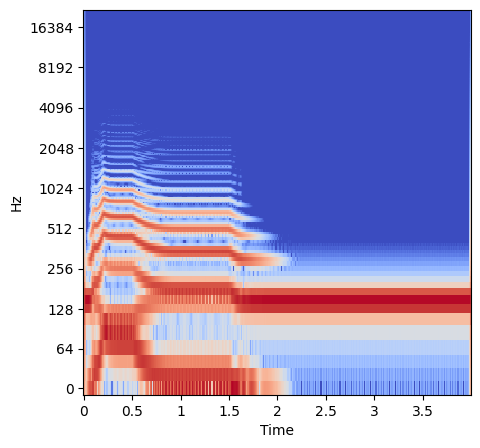

In [16]:
# Set up a Keyboard module
keyboard = MonophonicKeyboard(
    config=config1,
    PRNG_key=PRNG_key.split(),
    midi_f0=jnp.array([50.0, 50.0]),
)

# Trigger the keyboard, which returns a midi_f0 and note duration
params = keyboard.init(PRNG_key.split())
apply = jax.jit(keyboard.apply)
midi_f0, duration = apply(params)


# Instantiate the sine wave VCO
sine_vco = SineVCO(
    config=config1,
    PRNG_key=PRNG_key.split(),
    tuning=jnp.array([0.0, 0.0]),
    mod_depth=jnp.array([0.0, 5.0]),
)

# Call the sine_vco with the midi_f0
params = sine_vco.init(PRNG_key.split(), midi_f0, envelope)
apply = jax.jit(sine_vco.apply)
sine_out = apply(params, midi_f0, envelope)

vca = VCA(config=config1, PRNG_key=PRNG_key.split())

params = vca.init(PRNG_key.split(), envelope, sine_out)
apply = jax.jit(vca.apply)
sine_out = apply(params, envelope, sine_out)

# Instantiate the FM VCO
fm_vco = FmVCO(
    config=config1,
    PRNG_key=PRNG_key.split(),
    tuning=jnp.array([0.0, 0.0]),
    mod_depth=jnp.array([2.0, 5.0]),
)

params = sine_vco.init(PRNG_key.split(), midi_f0, sine_out)
apply = jax.jit(fm_vco.apply)
fm_out = apply(params, midi_f0, sine_out)

stft_plot(fm_out[0])
ipd.display(ipd.Audio(fm_out[0], rate=fm_vco.sample_rate))

stft_plot(fm_out[1])
ipd.display(ipd.Audio(fm_out[1], rate=fm_vco.sample_rate))

### Noise

The noise generator creates white noise the same length as the SynthModule buffer length

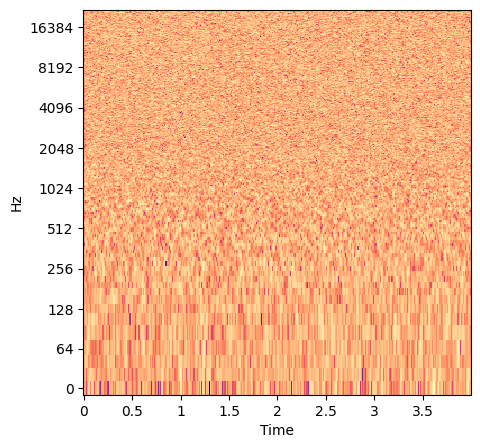

In [17]:
noise = Noise(
    config=config1,
    PRNG_key=PRNG_key.split(),
)

# Call the sine_vco with the midi_f0
params = noise.init(PRNG_key.split())
apply = jax.jit(noise.apply)
out = apply(params)

stft_plot(out[0])
ipd.Audio(out[0], rate=noise.sample_rate)

## Audio Mixer

In [18]:
env = jnp.zeros((config1.batch_size, config1.buffer_size))

keyboard = MonophonicKeyboard(config=config1, PRNG_key=PRNG_key.split())
sine_vco = SineVCO(config=config1, PRNG_key=PRNG_key.split())
square_saw = SquareSawVCO(config=config1, PRNG_key=PRNG_key.split())
noise = Noise(config=config1, PRNG_key=PRNG_key.split())

params = keyboard.init(PRNG_key.split())
apply = jax.jit(keyboard.apply)
midi_f0, note_on_duration = apply(params)

params = sine_vco.init(PRNG_key.split(), midi_f0, env)
apply = jax.jit(sine_vco.apply)
sine_out = apply(params, midi_f0, env)

params = square_saw.init(PRNG_key.split(), midi_f0, env)
apply = jax.jit(square_saw.apply)
sqr_out = apply(params, midi_f0, env)

params = noise.init(PRNG_key.split())
apply = jax.jit(noise.apply)
noise_out = apply(params)

In [19]:
mixer = AudioMixer(config=config1, PRNG_key=PRNG_key.split(), n_input=3)

params = mixer.init(PRNG_key.split(), sine_out, sqr_out, noise_out)
apply = jax.jit(mixer.apply)
out = apply(params, sine_out, sqr_out, noise_out)

ipd.Audio(out[0], rate=mixer.sample_rate, normalize=False)

We can also change the levels when initializing the mixer

In [20]:
mixer = AudioMixer(
    config=config1,
    PRNG_key=PRNG_key.split(),
    n_input=3,
    level=jnp.array([0.25, 0.25])
)

params = mixer.init(PRNG_key.split(), sine_out, sqr_out, noise_out)
apply = jax.jit(mixer.apply)
out = apply(params, sine_out, sqr_out, noise_out)

ipd.Audio(out[0], rate=mixer.sample_rate, normalize=False)

In [21]:
mixer = AudioMixer(
    config=config1,
    PRNG_key=PRNG_key.split(),
    n_input=3,
    level=jnp.array([0.125, 0.125])
)

params = mixer.init(PRNG_key.split(), sine_out, sqr_out, noise_out)
apply = jax.jit(mixer.apply)
out = apply(params, sine_out, sqr_out, noise_out)

ipd.Audio(out[0], rate=mixer.sample_rate, normalize=False)

## Modulation

Besides envelopes, LFOs can be used to modulate parameters

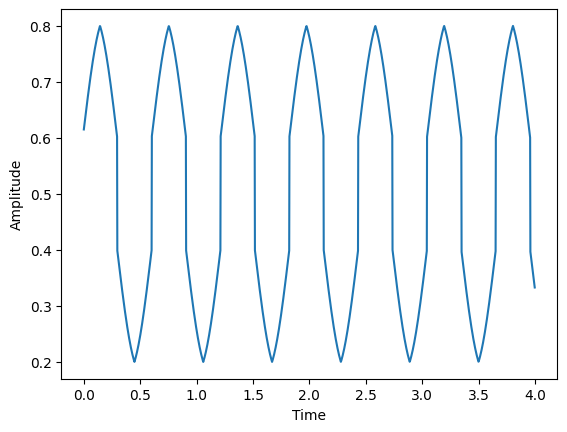

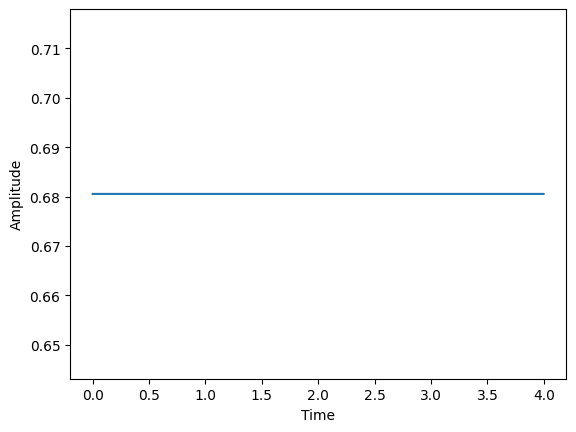

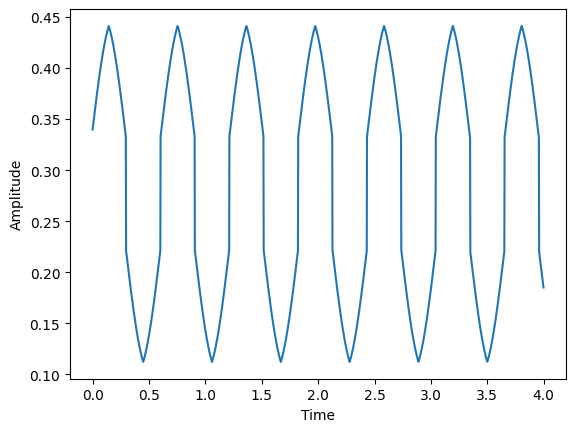

In [22]:
lfo = LFO(
    config=config1,
    PRNG_key=PRNG_key.split(),
    mod_depth=jnp.array([10.0, 0.0]),
    frequency=jnp.array([1.0, 1.0]),
)

params = lfo.init(PRNG_key.split())
apply = jax.jit(lfo.apply)
out = apply(params)

keyboard = MonophonicKeyboard(
    config=config1,
    PRNG_key=PRNG_key.split(),
)

params = keyboard.init(PRNG_key.split())
apply = jax.jit(keyboard.apply)
midi_f0, duration = apply(params)

adsr = ADSR(
    config=config1,
    PRNG_key=PRNG_key.split(),
)

params = adsr.init(PRNG_key.split(), duration)
apply = jax.jit(adsr.apply)
envelope = apply(params, duration)

lfo2 = LFO(
    config=config1,
    PRNG_key=PRNG_key.split(),
)

params = lfo2.init(PRNG_key.split(), envelope)
apply = jax.jit(lfo2.apply)
out2 = apply(params, envelope)

time_plot(out[0], sample_rate=lfo.control_rate)
time_plot(out2[0], sample_rate=lfo.control_rate)

# A modulation mixer can be used to mix a modulation sources together
# and maintain a 0 to 1 amplitude range
mixer = ModulationMixer(
    config=config1,
    PRNG_key=PRNG_key.split(),
    n_input=2,
    n_output=1)

params = mixer.init(PRNG_key.split(), out, out2)
apply = jax.jit(mixer.apply)
mods_mixed = apply(params, out, out2)

time_plot(mods_mixed[0][0], sample_rate=lfo.control_rate)

## Voice Synthesizer

Alternately, you can just use the Voice class that composes all these modules
together automatically.

In [23]:
synth = Voice(PRNG_key=PRNG_key.split(), config=config2)
params = synth.init(PRNG_key.split())
apply = jax.jit(synth.apply)
audio = apply(params)

In [24]:
flat_params, _ = jax.tree_util.tree_flatten(params)

print("Parameters: ", jnp.array(flat_params).squeeze().shape)
print("Audio (batch, sample rate * seconds): ", audio.shape)

Parameters:  (127,)
Audio (batch, sample rate * seconds):  (1, 176400)


In [25]:
ipd.Audio(audio, rate=synth.sample_rate)

## Parametric Synthesizer

We can also define a synthesizer with random parameters based on the number of `SineVCO`, `SquareSawVCO`, and `FmVCO`.

In [26]:
synth = ParametricSynth(
    PRNG_key=PRNG_key.split(),
    config=config2,
    sine=1,
    square_saw=1,
    fm_sine=1,
    fm_square_saw=0,
)
params = synth.init(PRNG_key.split())
apply = jax.jit(synth.apply)
audio = apply(params)

In [27]:
flat_params, _ = jax.tree_util.tree_flatten(params)

print("Parameters: ", jnp.array(flat_params).squeeze().shape)
print("Audio (batch, sample rate * seconds): ", audio.shape)

Parameters:  (131,)
Audio (batch, sample rate * seconds):  (1, 176400)


In [28]:
ipd.Audio(audio, rate=synth.sample_rate)

## TODO: Load/Save Synthesizer